In [132]:
# load required libraries: you may need to install netCDF4
from defaults import *
%matplotlib inline

In [133]:
# load up the datasets we want
# 
# Mostly, this is the Ab data at this point
# but we will also load v3.0 or v2.0 data for support
#

datakeys = np.array(['bbdr.meris', 'bbdr.vgt', 'ga.brdf.merge',\
       'ga.brdf.nosnow', 'ga.brdf.snow', 'mod09', 'myd09',\
       'prior.v2.nosnow', 'prior.v2.snow', 'prior.v2.snownosnow'])
# load the datasets into a dictionary in ncdata
ncdata = {}
abdata = {}
for k in datakeys:
    try:
        abdata[k] = load_obj('obj/'+ k + '_Ab_' )
        print '\nAb',k,
    except:
        pass
    try:
        ncdata[k] = load_obj('obj/'+ k + '_s3.0_' )
        print '\n\t3',k,
    except:
        ncdata[k] = load_obj('obj/'+ k + '_s2.0_' )
        print '\n\t\t2',k,
        
        
nbands,nk = ncdata['mod09']['kernels'].shape[0:2]
nskip = nbands *nk


Ab bbdr.meris 
	3 bbdr.meris 
Ab bbdr.vgt 
	3 bbdr.vgt 
		2 ga.brdf.merge 
		2 ga.brdf.nosnow 
		2 ga.brdf.snow 
Ab mod09 
	3 mod09 
Ab myd09 
	3 myd09 
Ab prior.v2.nosnow 
		2 prior.v2.nosnow 
Ab prior.v2.snow 
		2 prior.v2.snow 
		2 prior.v2.snownosnow


In [134]:
print 'Ab data available for',abdata.keys()
print
print 'The keys inside Ab data:',abdata['mod09'].keys()

Ab data available for ['myd09', 'bbdr.vgt', 'prior.v2.snow', 'mod09', 'prior.v2.nosnow', 'bbdr.meris']

The keys inside Ab data: ['A', 'b', 'd0', 'doys']


myd09 LinregressResult(slope=0.53777728145524295, intercept=0.048138203975339487, rvalue=0.73333299493146065, pvalue=3.7566101133364316e-229, stderr=0.013549321168984335)

bbdr.vgt LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan)

prior.v2.snow
mod09 LinregressResult(slope=0.88779560933878443, intercept=0.014780745434952114, rvalue=0.94222906415506547, pvalue=0.0, stderr=0.0067520508072927794)

prior.v2.nosnow
bbdr.meris LinregressResult(slope=0.82101910957050872, intercept=0.026311118684937684, rvalue=0.9136519360745281, pvalue=0.0, stderr=0.011431873036146515)



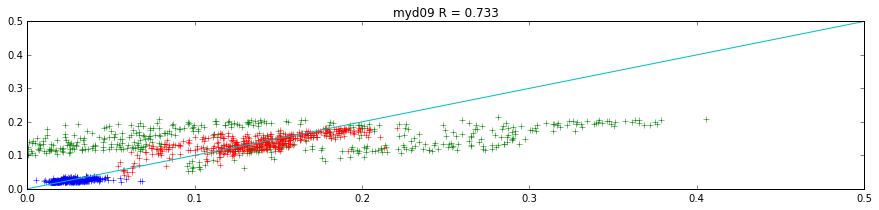

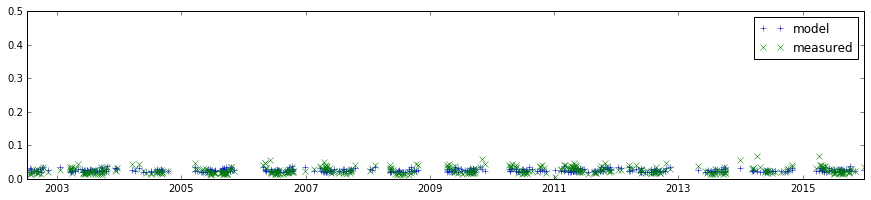

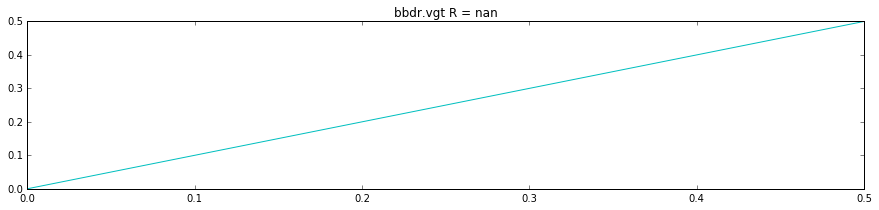

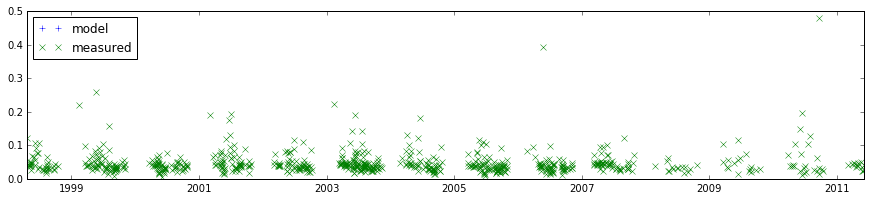

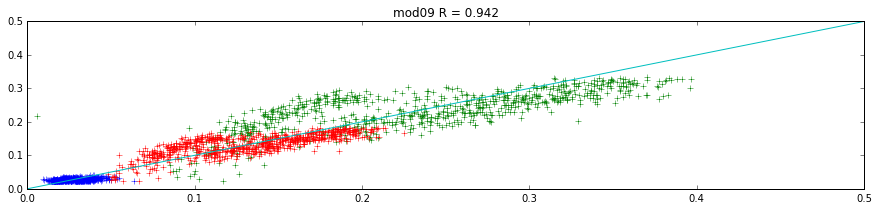

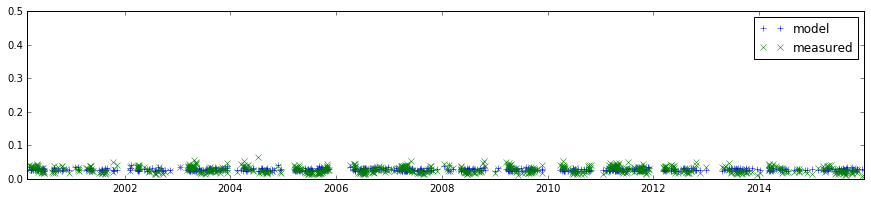

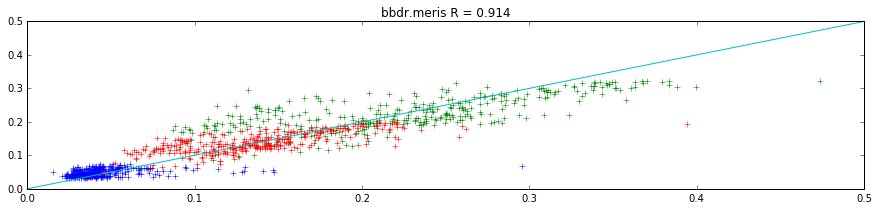

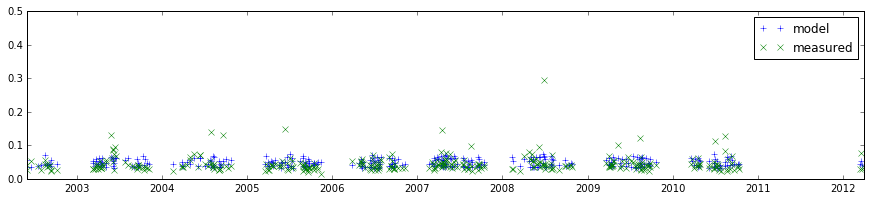

In [135]:
def subblock(A,i,j=None,nskip=9):
    '''
    Pull subblock i (,j) from A
    '''
    sli = slice(i*nskip,(i+1)*nskip)
    if A.shape[1] == 1:
        try:
            return A[sli,0].todense()
        except:
            return A[sli,0]
    if j == None: j = i
    slj = slice(j*nskip,(j+1)*nskip)
    try:
        return A[sli,slj].todense()
    except:
        return A[sli,slj]


# solve for each observation dataset, assuming constant over time
for sensor in abdata.keys():
    A,b,d0 = abdata[sensor]['A'],abdata[sensor]['b'],abdata[sensor]['d0']
    Ablocks = np.array([subblock(A,i) for i in xrange(A.shape[0]/nskip)])
    # shape is eg (6483, 9, 9)
    bblocks = np.array([subblock(b,i) for i in xrange(A.shape[0]/nskip)])
    # shape is eg (6483, 9, 1)
    A = Ablocks.sum(axis=0)
    b = bblocks.sum(axis=0)
    x = np.linalg.solve(A,b)
    
    # for fwd modelling
    xx = np.zeros((nbands,x.size))
    # and add x elements
    for i in xrange(nbands):
        sl = slice(i*nk,(i+1)*nk)
        xx[i,sl] = x[sl,0] 
    
    print sensor,
    try:
        t = ncdata[sensor]['idoy']
        ss = ncdata[sensor]['kernels'].shape
        # Note the need to swap axes 0 and 1 here to more 
        # simply define the k matrix
        k = np.swapaxes(ncdata[sensor]['kernels'],0,1).reshape((nskip,ss[-1])).T
        plt.figure(figsize=(15,3))
        yhat = np.dot(k,xx.T)
        yobs = ncdata[sensor]['refl']
        #print yhat.shape
        plt.plot(yobs.T,yhat,'+')
        #import pdb;pdb.set_trace()
        txt = scipy.stats.linregress(np.array(yobs).T.flatten(),np.array(yhat).flatten())
        print txt
        plt.title(sensor + ' R = %.3f'%txt[2])
        plt.xlim(0,0.5)
        plt.ylim(0,0.5)
        plt.plot([0.,1],[0.,1])
        tt = np.array([timedelta(ti)+d0 for ti in t])
        plt.figure(figsize=(15,3))
        plt.plot(tt,yhat[:,0],'+',label='model')
        plt.plot(tt,yobs.T[:,0],'x',label='measured')
        plt.legend(loc='best')
        plt.ylim(0,0.5)
        #print yhat.shape
    except:
        pass

    print
#plt.legend()

In [124]:
t.shape,yhat[:,0].shape

((341,), (341,))

(341, 3) yhat [[ 0.22757435 -0.03487614 -0.37474775]
 [ 0.22757435  0.00673444 -0.22492121]
 [ 0.22757435 -0.03409486 -0.35919109]
 ..., 
 [ 0.22757435  0.02200898 -0.39035489]
 [ 0.22757435 -0.00803775 -0.43535073]
 [ 0.22757435 -0.02072663 -0.41263305]]
(341, 3) yobs [[ 0.02774778  0.26135752  0.14873891]
 [ 0.04104404  0.30687776  0.17774425]
 [ 0.05434554  0.25020015  0.15697248]
 ..., 
 [ 0.07736591  0.16862069  0.12694733]
 [ 0.03070962  0.09718701  0.06625514]
 [ 0.03567156  0.11665931  0.07836626]]


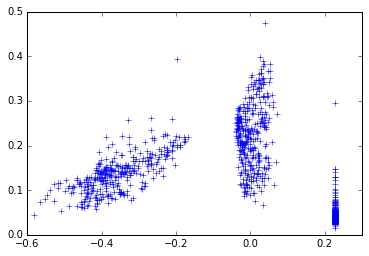

In [87]:
#yhat0 = np.dot(k,xx.T).T
yhat = np.array(np.matrix(k)*np.matrix(xx.T))
print yhat0.shape,'yhat',yhat0
yobs = ncdata[sensor]['refl'].T
print yobs.shape,'yobs',yobs
kk = k.reshape(k.shape[0],nk,nbands)
#yhat = np.dot(kk.T.reshape(k.shape),xx.T)
plt.plot(yhat.flatten(),yobs.flatten(),'+')

In [59]:
k = ncdata[sensor]['kernels'].reshape((nskip,ss[-1])).T

In [61]:
k.shape

(341, 9)

In [55]:
yobs = ncdata[sensor]['refl']
yobs.shape

(3, 341)

In [56]:
yhat = np.dot(ncdata[sensor]['kernels'].reshape((nskip,ss[-1])).T,x).flatten()
yhat.shape

(341,)

In [62]:
x.shape

(9, 1)

In [66]:
x[0:nk].T

array([[ 0.06286764,  0.1509137 ,  0.01379301]])

In [67]:
k

array([[ 1.        ,  1.        ,  1.        , ..., -1.19684756,
        -1.20899451, -1.20682871],
       [ 1.        ,  1.        ,  1.        , ..., -0.72405279,
        -0.56876802, -0.65865952],
       [ 1.        ,  1.        ,  1.        , ..., -1.14762247,
        -1.14682031, -1.15165496],
       ..., 
       [ 1.        ,  1.        ,  1.        , ..., -1.24314833,
        -1.22011936, -1.25345075],
       [ 1.        ,  1.        ,  1.        , ..., -1.38257456,
        -1.4692111 , -1.44313443],
       [ 1.        ,  1.        ,  1.        , ..., -1.31421745,
        -1.35393941, -1.34553981]], dtype=float32)